In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Explore and understand Data
#Create inspector and connect it to engine
inspector=inspect(engine)

#collect table names of the data base
tables=inspector.get_table_names()

#Use inspector to print column names within each table and its types
for table in tables:
    print(table)
    columns=inspector.get_columns(table)
    for column in columns:
        print(column["name"],column["type"])
        
    print()

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [6]:
#ANOTHER WAY TO FIND TABLES/CLASSES

In [7]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table
meas = base.classes.measurement 
sta = base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
query="SELECT max(date) from measurement;"

data=engine.execute(text(query))
for record in data:
    print(record)

('2017-08-23',)


In [12]:
#Another way to get most recent date using session
most_recent_date = session.query(meas.date).order_by(meas.date.desc()).first()
most_recent_date


('2017-08-23',)

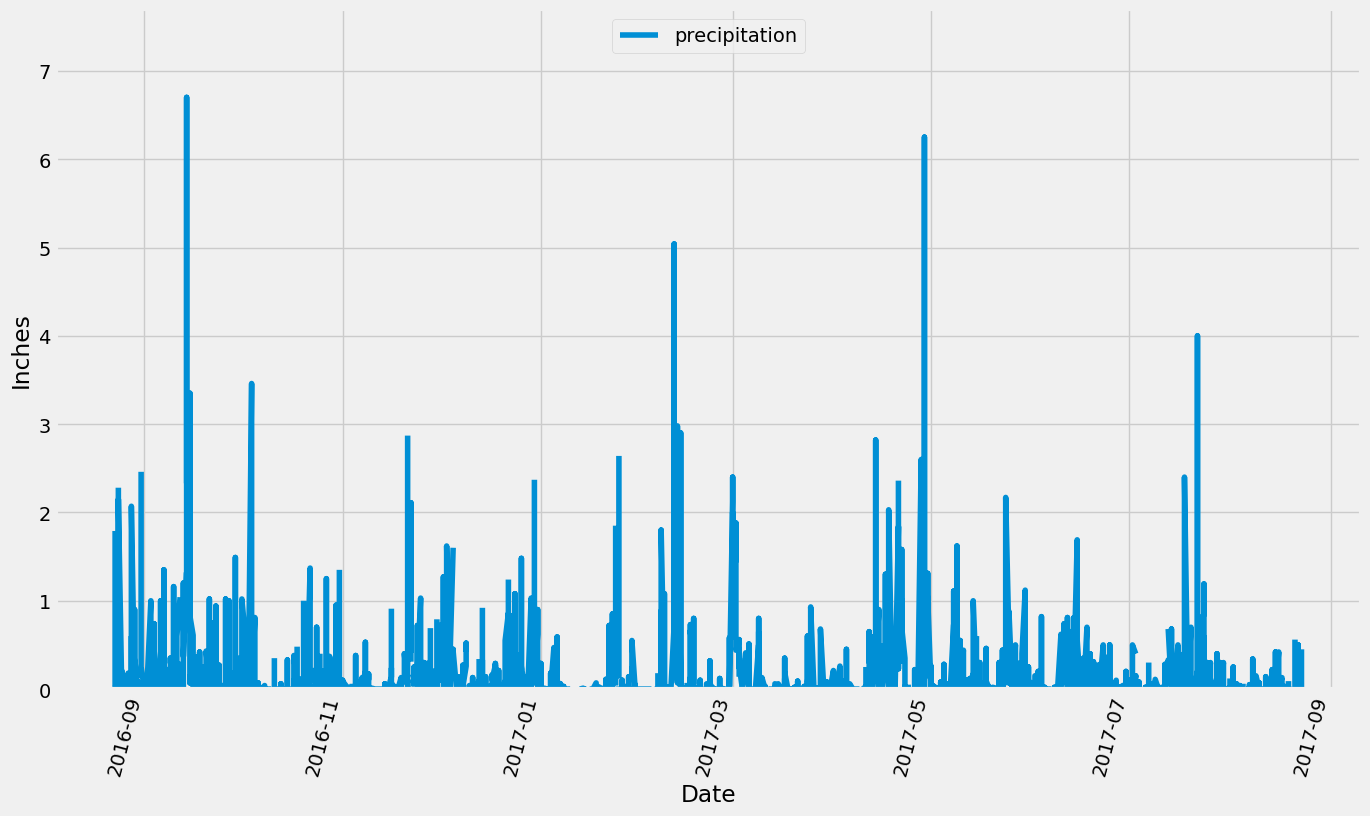

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.date(2017,8,23)
# Calculate the date one year from the last date in data set.
year_from_last_date = most_recent_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(meas.date, meas.prcp).filter(meas.date >= year_from_last_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
meas_df = pd.DataFrame(prcp_query).rename(columns = {'prcp': 'precipitation'})

# Format Dates
meas_df['date'] = pd.to_datetime(meas_df['date'], format = '%Y-%m-%d')

#set index to date
meas_df = meas_df.set_index('date')
# Sort the dataframe by date
meas_df = meas_df.sort_values(by = ['date'])

# Use Pandas Plotting with Matplotlib to plot the data
meas_df.plot(figsize = (15,10), rot=75)
plt.ylim(0,7.7)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.legend(loc = 'upper center')

In [14]:
#Another Way to get the same plot

query = """SELECT
                date,
                station,
                prcp
            FROM
                measurement
            WHERE
                date >= '2016-08-23';
"""

df=pd.read_sql(text(query), con=engine)
df.head()

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-24,USC00519397,0.08
2,2016-08-25,USC00519397,0.08
3,2016-08-26,USC00519397,0.00
4,2016-08-27,USC00519397,0.00


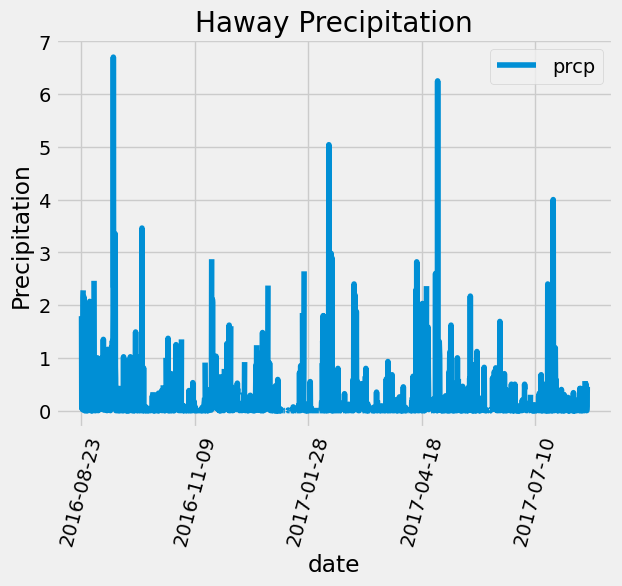

In [15]:
df=df.sort_values(by="date")

df.plot(kind="line", x="date",y="prcp",title="Haway Precipitation",ylabel="Precipitation",rot=75)
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
meas_stats = meas_df.describe()
meas_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
session.query(sta).first().__dict__
session.query(meas).first().__dict__
num = len(session.query(sta).all())
print(num)

9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

query="""SELECT
            station,
            count(id) as num_obs
        FROM
            measurement
        GROUP BY
            station
        ORDER BY
            num_obs desc;
"""

df_sta=pd.read_sql(text(query), con=engine)
df_sta

,station,num_obs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
#Another way to get the same result for
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

data=engine.execute(text(query))
for record in data:
    print(record)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query()
session.query(func.min(meas.tobs), func.max(meas.tobs), func.avg(meas.tobs)).\
filter(meas.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [38]:
query="""SELECT
            date,
            station,
            prcp
        FROM
            measurement
        WHERE
            date>= '2016-08-23'
            AND station = 'USC00519281';
"""

df3=pd.read_sql(text(query), con=engine)
df3.head()

,date,station,prcp
0,2016-08-23,USC00519281,1.79
1,2016-08-24,USC00519281,2.15
2,2016-08-25,USC00519281,0.06
3,2016-08-26,USC00519281,0.01
4,2016-08-27,USC00519281,0.12


In [26]:
#create query for temp observations for the histogram in the cell below
temp_obs = session.query(meas.tobs).\
filter(meas.station == 'USC00519281').\
filter(meas.date >= '2016-08-23').all()

#print
df_tobs = pd.DataFrame(temp_obs, columns=['tobs'])
print(df_tobs)

     tobs
0    77.0
1    77.0
2    80.0
3    80.0
4    75.0
..    ...
347  77.0
348  77.0
349  76.0
350  76.0
351  79.0

[352 rows x 1 columns]


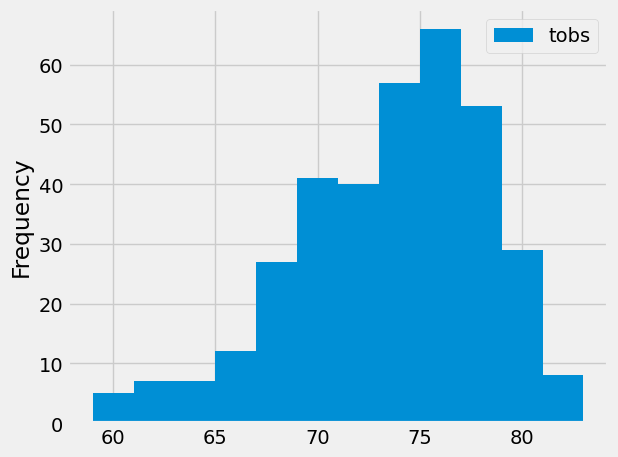

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_tobs.plot.hist(bins=12)
plt.tight_layout()

# Close Session

In [28]:
# Close Session
session.close()